# Producing a mock sample
White area on $\chi^2$ plot is due to underflows in erf function.
SED_fitting takest the following inputs:
```Python
SED_fitting(ν,F,Δ,model, limits,σ)
```
1. frequency
2. flux (or log-flux in this example)
3. True/False 1/0 array (1 if detection, 0 if upper-limit)
4. model (fitting function with frequency as first argument and parameters as second)
5. parameter limits [[parameter 1 low, parameter 1 high],[parameter 2 low, parameter 2 high],...]
6. Precomputed standard deviation


Following methods are available:
1. SED_fitting(ν,F,Δ,model).constrain_σ(θ) - estimates Weibull-fitting derived σ used in computing the Z-score from Sawicki+2012
2. SED_fitting.do_mcmc(ndim, nwalkers, Nsteps, priors,crop) - Computes MCMC estimate of a ```ndim```-dimensional model using ```nwalkers``` walkers evaluated at ```Nsteps``` steps using ```priors``` and without initial ```crop``` steps

In [3]:
%run "survival_fitter.py"

parameter 0: 0.974+/-0.030
parameter 1: -0.07+/-0.05


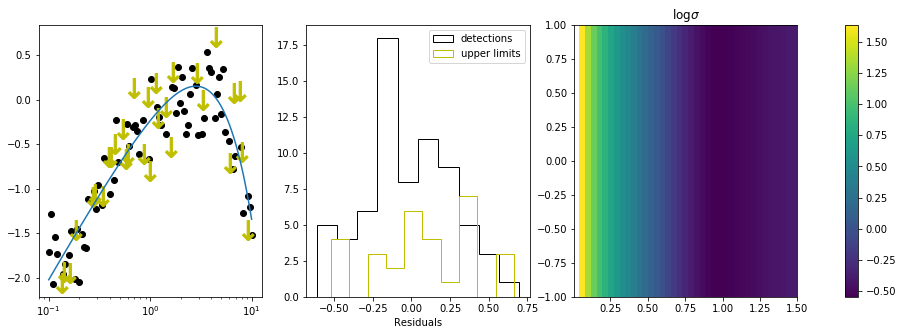

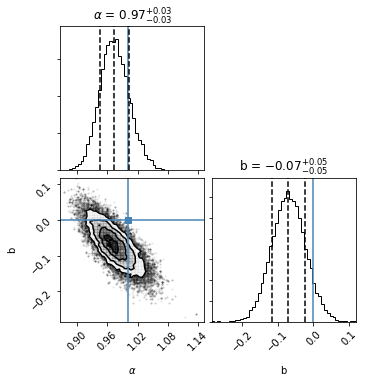

In [10]:
def model(x,θ):
    # Fake model α is θ[0], b is θ[1]
    return θ[1]+np.log10(x**3./(np.exp(x/θ[0])-1))
limits = np.array([[0.01,1.5],[-1,1]]) # Parameter bounds
θbf = np.array([1.,0]) # Simulated α and b
N   = 100 # Number of fake points
ν   = np.logspace(-1,1,N) # frequency axis
νt  = np.logspace(-1,1,100) # for plotting models
Fm  = model(ν,[1.,0.]) # model evaluation
F = Fm+np.random.normal(0.,.3,N) # Adding gaussian noise with σ=0.3

Δ = np.random.binomial(1,.7,N) # Detected 1, ULs 0
F[Δ==0]=F[Δ==0]+.09 # Simulating effects of upper limits

# Creating a mesh for plotting σ
θ0 = np.linspace(*limits[0],40) 
θ1 = np.linspace(*limits[1],40)
M  = np.meshgrid(θ0,θ1)
θ  = np.c_[M[0].flatten(),M[1].flatten()]
def checknan(f,θ):
    # checks if σ converges, otherwise returns inf
    try:
        return f(θ)
    except:
        return np.inf
σ_array = np.array([checknan(SED_fitting(ν,F,Δ,model).constrain_σ,θθ) for θθ in θ])
σ = np.min(σ_array) # smallest σ on the mesh

# Plotting σ on the mesh
f, ax = plt.subplots(1,3,figsize=(17,5))
ax[0].plot(ν[Δ==1],F[Δ==1],'ko')
ax[0].plot(ν[Δ==0],F[Δ==0],'y.',marker='$\downarrow$',ms=20)
ax[0].plot(νt,model(νt, θbf))
ax[0].set_xscale('log')
ax[1].set_xlabel('Residuals')
ax[1].hist(F[Δ==1]-Fm[Δ==1],10,color='k',histtype='step', label='detections')
ax[1].hist(F[Δ==0]-Fm[Δ==0],10,color='y',histtype='step',label='upper limits')
ax[1].legend()
ax[2].set_title('$\log\sigma$')
im=ax[2].pcolormesh(M[0],M[1],np.log10(σ_array).reshape(len(θ1),len(θ1)))
f.colorbar(im,ax=ax);

# MCMC
# using 100 walkers and uniform priors
ndim, nwalkers = 2, 100

p0 = np.c_[np.random.uniform(limits[0,0],limits[0,1],nwalkers),
           np.random.uniform(limits[1,0],limits[1,1],nwalkers)]
S = SED_fitting(ν,F,Δ,model, limits,σ=σ)
S.do_mcmc(ndim=2, nwalkers=100, Nsteps=500, priors=p0,crop=50)
corner(S.D,50,labels=[r'$\alpha$','b'], 
       show_titles=True,truths=θbf,quantiles=[.16,.5,.84]);
for i in range(2): print('parameter %d:'%i, ufloat(np.mean(S.D[:,i]),np.std(S.D[:,i])))

# Smaller dataset

parameter 0: 1.01+/-0.07
parameter 1: 0.01+/-0.17


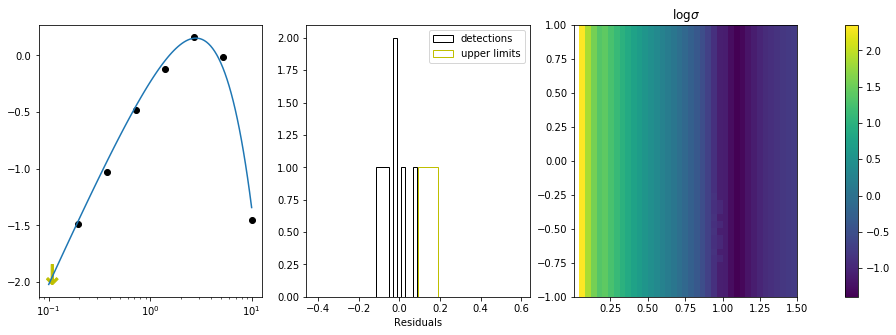

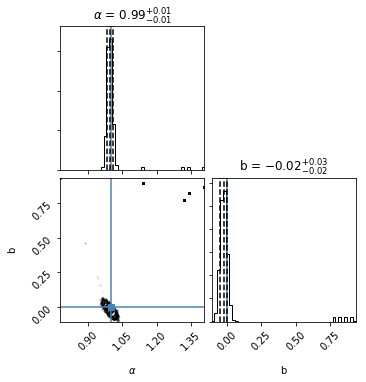

In [9]:
def model(x,θ):
    # Fake model α is θ[0], b is θ[1]
    return θ[1]+np.log10(x**3./(np.exp(x/θ[0])-1))
limits = np.array([[0.01,1.5],[-1,1]]) # Parameter bounds
θbf = np.array([1.,0]) # Simulated α and b
N   = 8 # Number of fake points
ν   = np.logspace(-1,1,N) # frequency axis
νt  = np.logspace(-1,1,100) # for plotting models
Fm  = model(ν,[1.,0.]) # model evaluation
F = Fm+np.random.normal(0.,.1,N) # Adding gaussian noise with σ=0.1

Δ = np.random.binomial(1,.8,N) # Detected 1, ULs 0
F[Δ==0]=F[Δ==0]+.09 # Simulating effects of upper limits

# Creating a mesh for plotting σ
θ0 = np.linspace(*limits[0],40) 
θ1 = np.linspace(*limits[1],40)
M  = np.meshgrid(θ0,θ1)
θ  = np.c_[M[0].flatten(),M[1].flatten()]
def checknan(f,θ):
    # checks if σ converges, otherwise returns inf
    try:
        return f(θ)
    except:
        return np.inf
σ_array = np.array([checknan(SED_fitting(ν,F,Δ,model).constrain_σ,θθ) for θθ in θ])
σ = np.min(σ_array) # smallest σ on the mesh

# Plotting σ on the mesh
f, ax = plt.subplots(1,3,figsize=(17,5))
ax[0].plot(ν[Δ==1],F[Δ==1],'ko')
ax[0].plot(ν[Δ==0],F[Δ==0],'y.',marker='$\downarrow$',ms=20)
ax[0].plot(νt,model(νt, θbf))
ax[0].set_xscale('log')
ax[1].set_xlabel('Residuals')
ax[1].hist(F[Δ==1]-Fm[Δ==1],10,color='k',histtype='step', label='detections')
ax[1].hist(F[Δ==0]-Fm[Δ==0],10,color='y',histtype='step',label='upper limits')
ax[1].legend()
ax[2].set_title('$\log\sigma$')
im=ax[2].pcolormesh(M[0],M[1],np.log10(σ_array).reshape(len(θ1),len(θ1)))
f.colorbar(im,ax=ax);

# MCMC
# using 100 walkers and uniform priors
ndim, nwalkers = 2, 100

p0 = np.c_[np.random.uniform(limits[0,0],limits[0,1],nwalkers),
           np.random.uniform(limits[1,0],limits[1,1],nwalkers)]
S = SED_fitting(ν,F,Δ,model, limits,σ=σ)
S.do_mcmc(ndim=2, nwalkers=100, Nsteps=500, priors=p0,crop=50)
corner(S.D,50,labels=[r'$\alpha$','b'], 
       show_titles=True,truths=θbf,quantiles=[.16,.5,.84]);
for i in range(2): print('parameter %d:'%i, ufloat(np.mean(S.D[:,i]),np.std(S.D[:,i])))